In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

### This template is for
- objFuncs: v1.0.4  
- pyBO: v1.0.2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import objFuncs
from objFuncs import VM, objFuncGoals, construct_machineIO
from objFuncs.preset import get_preset, get_tolerance, get_limits
from pyBO import pyBO
from pyBO.util import plot_2D_projection

objFuncs version: 1.0.4. updated on 2024-03-26
flame_utils is not importable. ignoreing this feature...
pyBO version: 1.0.2. updated on 2024-03-26


In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
# from phantasy import caget,fetch_data
import pandas as pd
np.random.seed(1)

# user inputs
### check and adjust decision (control knobs) and objectives later

In [7]:
is_close_to_opt = True     # True for local optimization. 
FC814 = 30                  # uA
timespan_for_average = 2.0  # sec  
additional_wait_after_powersupply_ramp  = 0.25 # sec

In [8]:
if is_close_to_opt:
    n_init_budget       = 4   # recommended: number of decision parameters 
    n_global_opt_budget = 0
    n_local_opt_budget  = 10
    n_finetune_budget   = 2   # recommended: less than number of decision parameters 
else:
    n_init_budget       = 10         
    n_global_opt_budget = 5
    n_local_opt_budget  = 5
    n_finetune_budget   = 2   # recommended: less than number of decision parameters 

budget = n_init_budget +n_global_opt_budget +n_local_opt_budget +n_finetune_budget
print(f"budget: {budget}")

budget: 16


# check machineIO, source and beam  

In [9]:
objFuncs._global_machineIO._test = True
objFuncs._global_machineIO._fetch_data_time_span = timespan_for_average
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = additional_wait_after_powersupply_ramp

In [10]:
SCS = 1
ion = 'Ca'
Q = 10
A = 16
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS1 16Ca10 A/Q= 1.6


In [11]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][pyBO][MEBT]FC1108'
fname

'20251120_1332[16Ca10][pyBO][MEBT]FC1108'

# preprare decision ( control knob)

In [12]:
# preset = get_preset('[MEBT]FC1102',offline=True)
# preset

In [13]:
decision_CSETs = [
                 'FE_LEBT:PSC2_D0964:I_CSET', 'FE_LEBT:PSC1_D0964:I_CSET',
#                  'FE_LEBT:PSC2_D0979:I_CSET', 'FE_LEBT:PSC1_D0979:I_CSET',
#                  'FE_LEBT:PSC2_D0992:I_CSET', 'FE_LEBT:PSC1_D0992:I_CSET',
                  ]
decision_min   = [ -5]*len(decision_CSETs)
decision_max   = [  5]*len(decision_CSETs)
decision_tols  = [0.2]*len(decision_CSETs)

pd.DataFrame(np.array([decision_min,decision_max,decision_tols]).T,
             index=decision_CSETs, 
             columns=['decision min','decision max','tol'])

,decision min,decision max,tol
FE_LEBT:PSC2_D0964:I_CSET,-5.0,5.0,0.2
FE_LEBT:PSC1_D0964:I_CSET,-5.0,5.0,0.2


# preprare objective function

In [14]:
objective_goal= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 0,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 0,
#     'FE_MEBT:BPM_D1056:PHASE_RD': 80.01379620843083,
#     'FE_MEBT:BPM_D1072:XPOS_RD' : 0.11800521457630664,
#     'FE_MEBT:BPM_D1072:YPOS_RD' : 0.4313544346071099,
#     'FE_MEBT:BPM_D1072:PHASE_RD': -23.42850231099402,
#     'FE_MEBT:BPM_D1094:XPOS_RD' : 0.04434067124873937,
#     'FE_MEBT:BPM_D1094:YPOS_RD' : -0.15548171891011758,
#     'FE_MEBT:BPM_D1094:PHASE_RD': -14.992799801690156,
    'FE_MEBT:BCM_D1055:AVGPK_RD': {'more than': FC814},
    'FE_MEBT:FC_D1102:PKAVG_RD' : {'more than': 0.8*FC814},
}

In [15]:
objective_norm= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 1,
#     'FE_MEBT:BPM_D1056:PHASE_RD': 1,
#     'FE_MEBT:BPM_D1072:XPOS_RD' : 1,
#     'FE_MEBT:BPM_D1072:YPOS_RD' : 1,
#     'FE_MEBT:BPM_D1072:PHASE_RD': 1,
#     'FE_MEBT:BPM_D1094:XPOS_RD' : 1,
#     'FE_MEBT:BPM_D1094:YPOS_RD' : 1,
#     'FE_MEBT:BPM_D1094:PHASE_RD': 1,
    'FE_MEBT:BCM_D1055:AVGPK_RD': 0.05*FC814,
    'FE_MEBT:FC_D1102:PKAVG_RD' : 0.05*0.8*FC814,
}

In [16]:
# set weight to zero if you don't want to include the corresponding objective

objective_weight= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 1,
#     'FE_MEBT:BPM_D1056:PHASE_RD': 0,  #1,
#     'FE_MEBT:BPM_D1072:XPOS_RD' : 0,  #0.4,
#     'FE_MEBT:BPM_D1072:YPOS_RD' : 0,  #0.4,
#     'FE_MEBT:BPM_D1072:PHASE_RD': 0,  #0.5,
#     'FE_MEBT:BPM_D1094:XPOS_RD' : 0,  #0.2,
#     'FE_MEBT:BPM_D1094:YPOS_RD' : 0,  #0.2,
#     'FE_MEBT:BPM_D1094:PHASE_RD': 0,  #0.25,
    'FE_MEBT:BCM_D1055:AVGPK_RD': 1,
    'FE_MEBT:FC_D1102:PKAVG_RD' : 1,
}

# construct VM

In [17]:
machineIO = construct_machineIO()
machineIO._test = True

In [18]:
objective_RDs_mean = []
for k,v in objective_goal.items():
    if isinstance(v, dict):
        v = list(v.values())[0]
    objective_RDs_mean.append(v - 2*objective_norm[k])

In [19]:
vm = VM(
    x0 = np.zeros(len(decision_CSETs)),
    decision_CSETs = decision_CSETs,
    decision_min   = decision_min,
    decision_max   = decision_max,
    objective_RDs  = list(objective_goal.keys()),
    objective_RDs_mean = objective_RDs_mean,
    objective_RDs_std  = [val for val in objective_norm.values()],
    real_time_delay = 2,
)

In [20]:
machineIO._ensure_set = vm.ensure_set
machineIO._fetch_data = vm.fetch_data
machineIO._caget      = vm.caget
machineIO._caput      = vm.caput

In [21]:
obj = objFuncGoals(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    apply_bilog = True,
    machineIO=machineIO,
)

======== class info ========
init_time: 2025-11-20 13:32:28.659668
class_hierarchy: [
    objFuncGoals, objFuncBase]
machineIO: not picklable
decision_CSETs: [
    FE_LEBT:PSC2_D0964:I_CSET, FE_LEBT:PSC1_D0964:I_CSET]
decision_min: [-5. -5.]
decision_max: [5. 5.]
decision_bounds: [[-5  5]
 [-5  5]]
decision_RDs: [
    FE_LEBT:PSC2_D0964:I_RD, FE_LEBT:PSC1_D0964:I_RD]
decision_tols: [0.2 0.2]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [0. 0.]
plot_time_val: <class 'objFuncs.util.plot_time_val'>
plot_obj_history: <class 'objFuncs.util.plot_obj_history'>
objective_weight:
    FE_MEBT:BPM_D1056:XPOS_RD: 0.25
    FE_MEBT:BPM_D1056:YPOS_RD: 0.25
    FE_MEBT:BCM_D1055:AVGPK_RD: 0.25
    FE_MEBT:FC_D1102:PKAVG_RD: 0.25
objective_goal:
    FE_MEBT:BPM_D1056:XPOS_RD: 0.0
    FE_MEBT:BPM_D1056:YPOS_RD: 0.0
    FE_MEBT:BCM_D1055:AVGPK_RD: {'more than': 30}
    FE_MEBT:FC_D1102:PKAVG_RD: {'more than': 24.0}
objective_norm:
    FE_

In [22]:
from matplotlib.patches import Rectangle

def plot_compare_acqu(ctrBO):
    bo = ctrBO.bo
    acqu_base, acqu_bounds = bo._prepare_acquisition(bounds = ctrBO.local_bounds)
    acqu_pneal, acqu_bounds = bo._prepare_acquisition(X_pending=ctrBO.X_pending, bounds=ctrBO.local_bounds)
    x = np.vstack((bo.x, ctrBO.X_pending))
    xmin=np.min(x,axis=0)
    xmax=np.max(x,axis=0)
    diff=xmax-xmin
    # bounds = np.array([(xmin[i]-0.1*diff[i],xmax[i]+0.1*diff[i]) for i in range(2)])
    fig,ax = plt.subplots(1,3,figsize=(12,3),dpi=128)
    bo.plot_model_2D_projection(epoch=-1,bounds=acqu_bounds,fig=fig,ax=ax[0],grid_ponits_each_dim=128)
    plot_2D_projection(acqu_base,bounds=acqu_bounds,fig=fig,ax=ax[1],grid_ponits_each_dim=128)
    plot_2D_projection(acqu_pneal,bounds=acqu_bounds,fig=fig,ax=ax[2],grid_ponits_each_dim=128)
    for i in range(3):
        ax[i].scatter(bo.x[:,0],bo.x[:,1],color='blue',s=10)
        ax[i].scatter(ctrBO.X_pending[:,0],ctrBO.X_pending[:,1],color='red',s=10)
        
    fig.tight_layout()
    plt.show()

In [23]:
from matplotlib.patches import Rectangle

def plot_compare_acqu(ctrBO):
    bo = ctrBO.bo
    acqu_base, acqu_bounds = bo._prepare_acquisition(bounds=ctrBO.local_bounds)
    acqu_pneal, _          = bo._prepare_acquisition(X_pending=ctrBO.X_pending,bounds=ctrBO.local_bounds)

    fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=128, sharex=True, sharey=True)
    bo.plot_model_2D_projection(
        epoch=-1, bounds=acqu_bounds, fig=fig, ax=ax[0], grid_ponits_each_dim=128
    )
    plot_2D_projection(acqu_base, bounds=acqu_bounds, fig=fig, ax=ax[1], grid_ponits_each_dim=128)
    plot_2D_projection(acqu_pneal, bounds=acqu_bounds, fig=fig, ax=ax[2], grid_ponits_each_dim=128)

    
    for i in range(3):
        ax[i].scatter(bo.x[:, 0], bo.x[:, 1], color='blue', s=10)
        ax[i].scatter(ctrBO.X_pending[:, 0], ctrBO.X_pending[:, 1], color='red', s=10)
        # Plot acqu_bounds rectangular region
        # rect = Rectangle(
        #     (acqu_bounds[0, 0], acqu_bounds[1, 0]),
        #     acqu_bounds[0, 1] - acqu_bounds[0, 0],
        #     acqu_bounds[1, 1] - acqu_bounds[1, 0],
        #     linewidth=2,
        #     edgecolor='green',
        #     facecolor='none',
        #     linestyle='--'
        # )
        # ax[i].add_patch(rect)
    fig.tight_layout()


# run Optim

In [24]:
ctrBO = pyBO.bo_controller(obj,local_optimization = is_close_to_opt)

init will random sample within the following bounds:


,min,max
FE_LEBT:PSC2_D0964:I_CSET,-1.0,1.0
FE_LEBT:PSC1_D0964:I_CSET,-1.0,1.0


scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


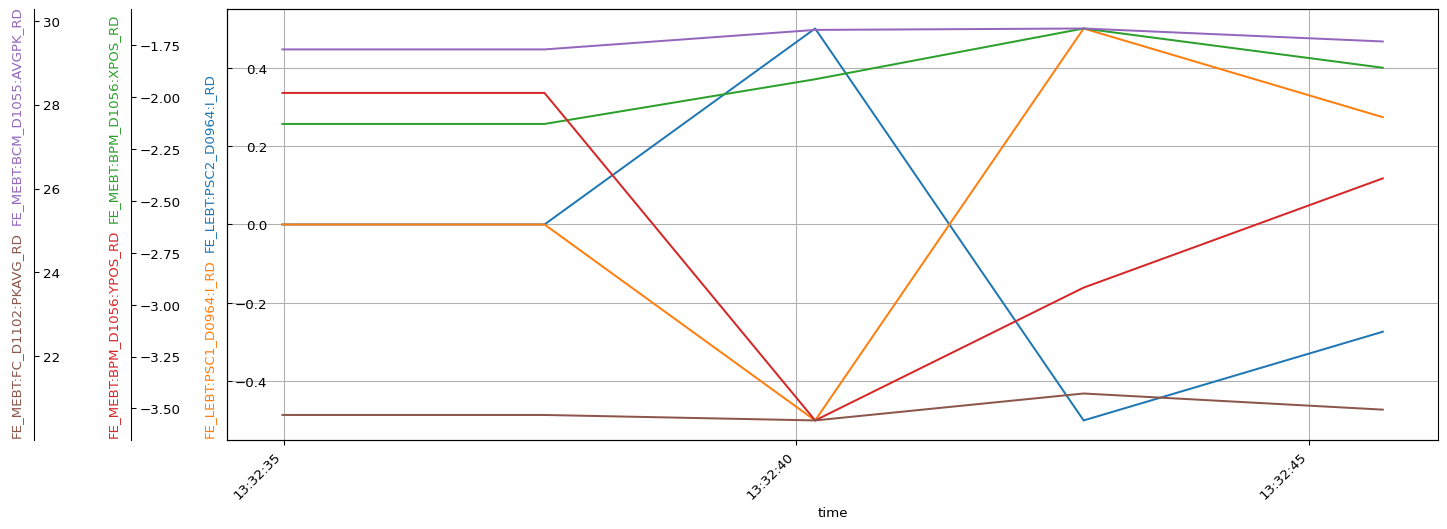

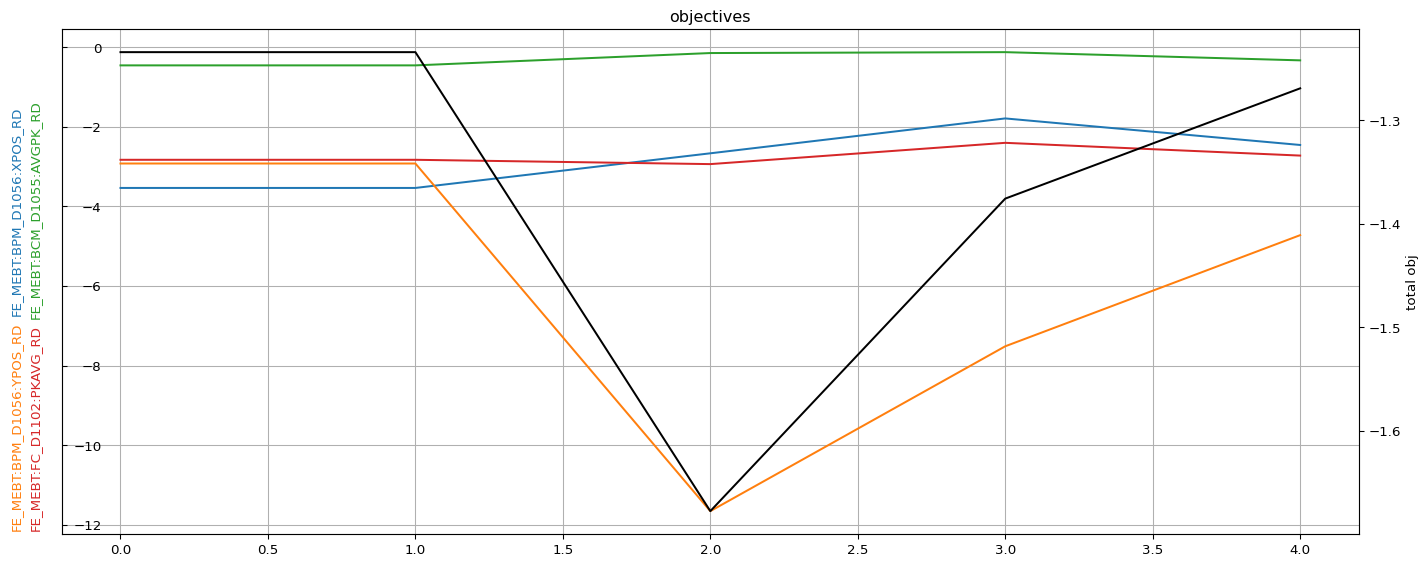

x data has duplicates. will remove duplicates and will average corresponding ys


In [25]:
# optimize
ctrBO.init(n_init_budget)  
for f in ctrBO.plot_callbacks:
    f.close()

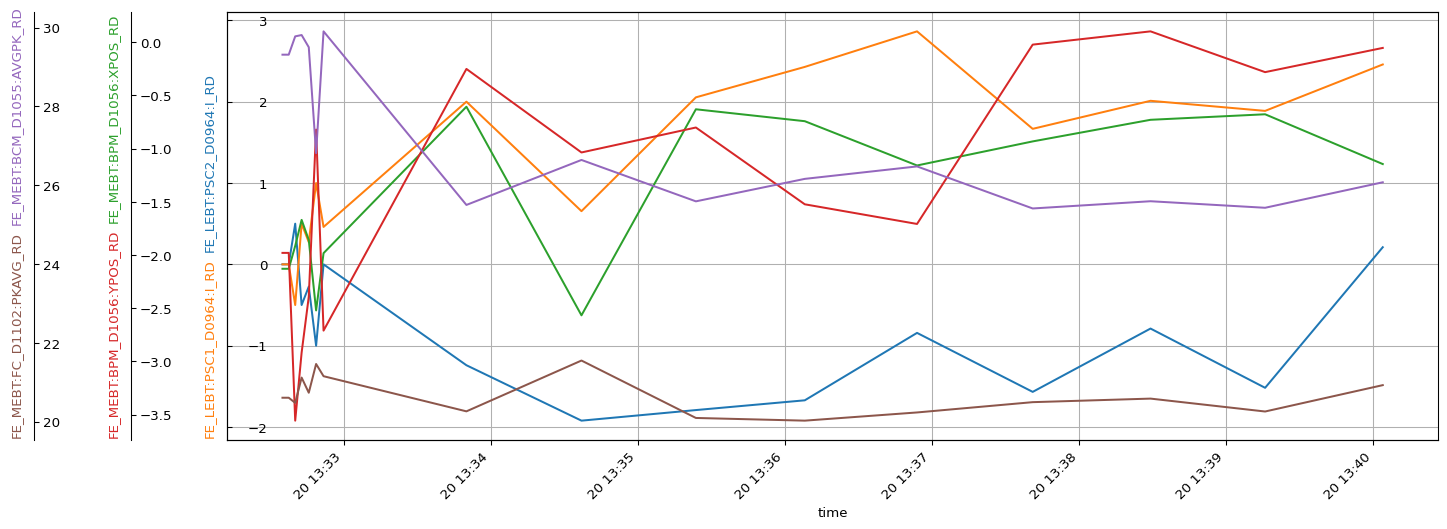

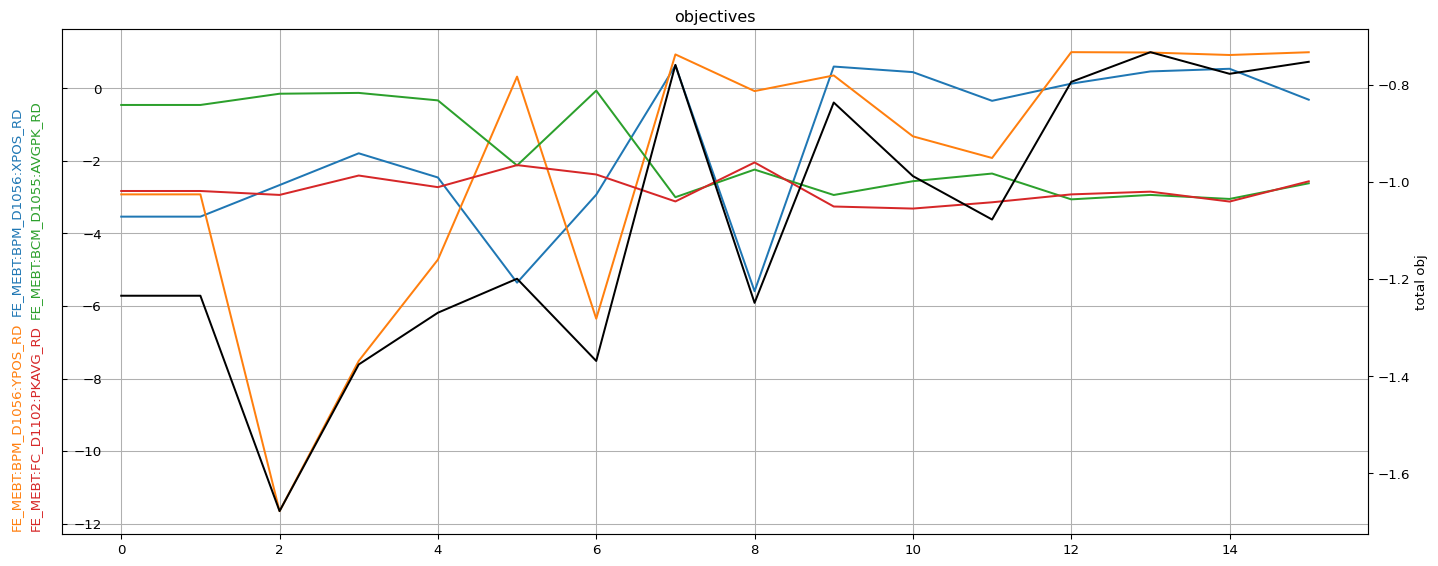

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

10 reduce Tr
[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[██████████████

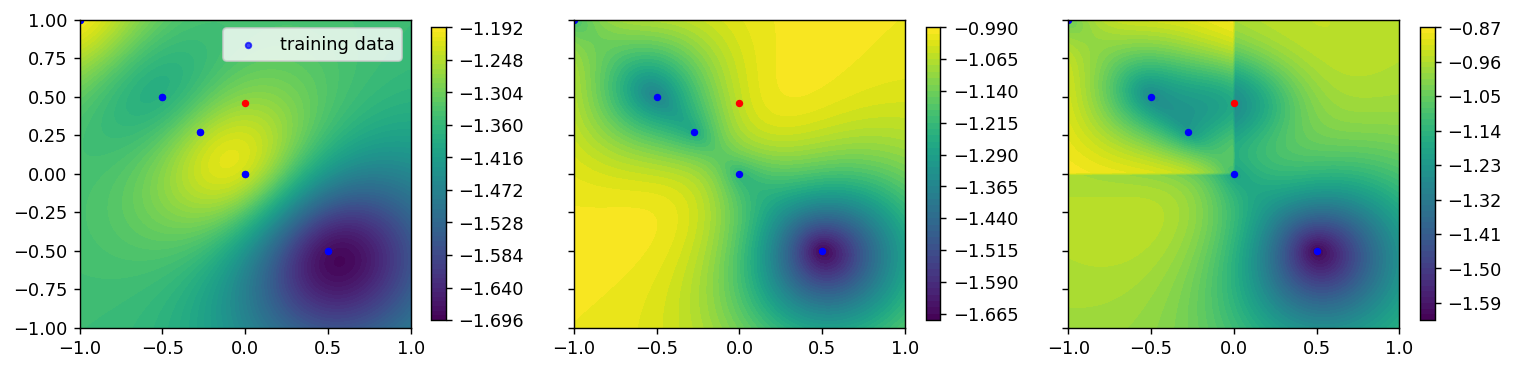

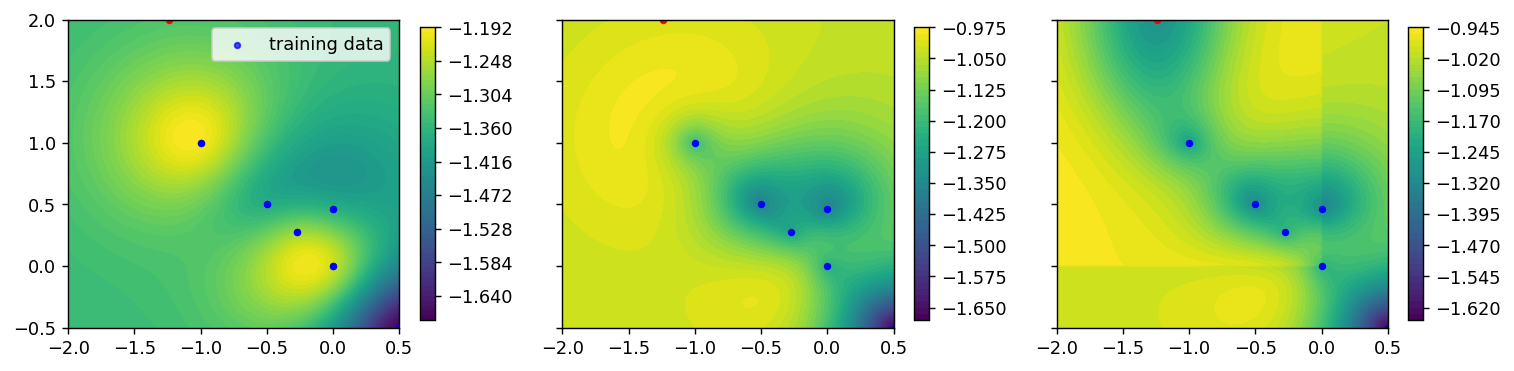

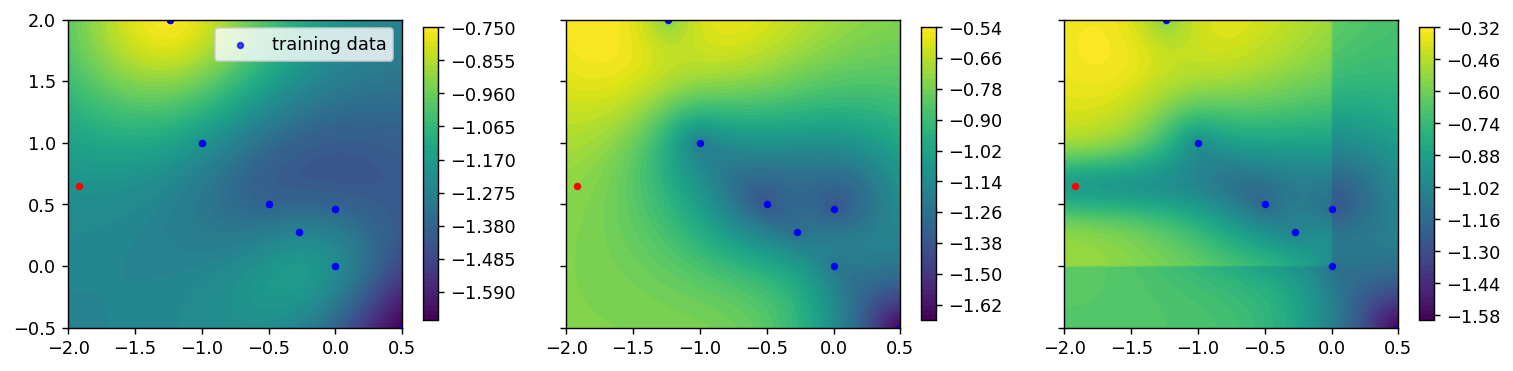

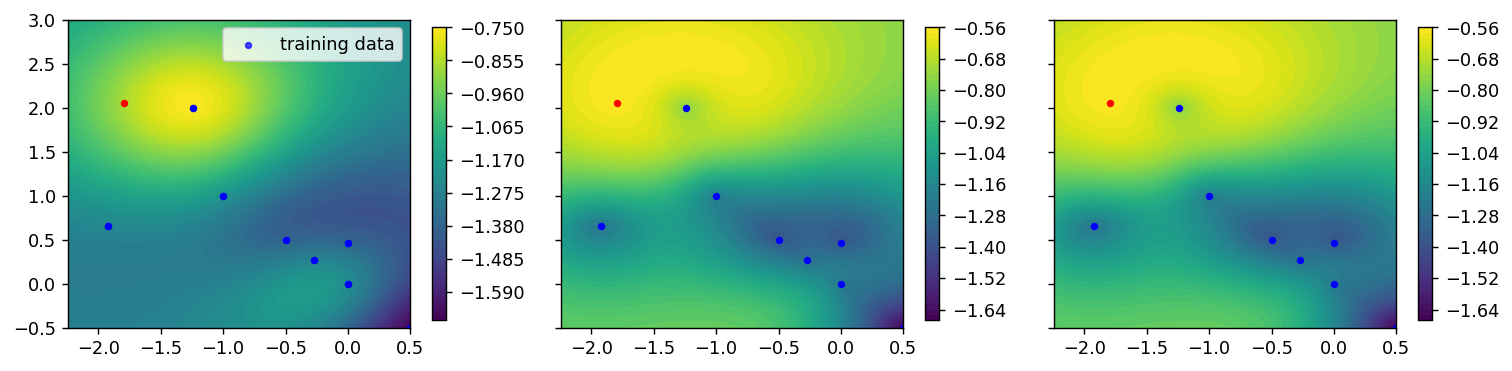

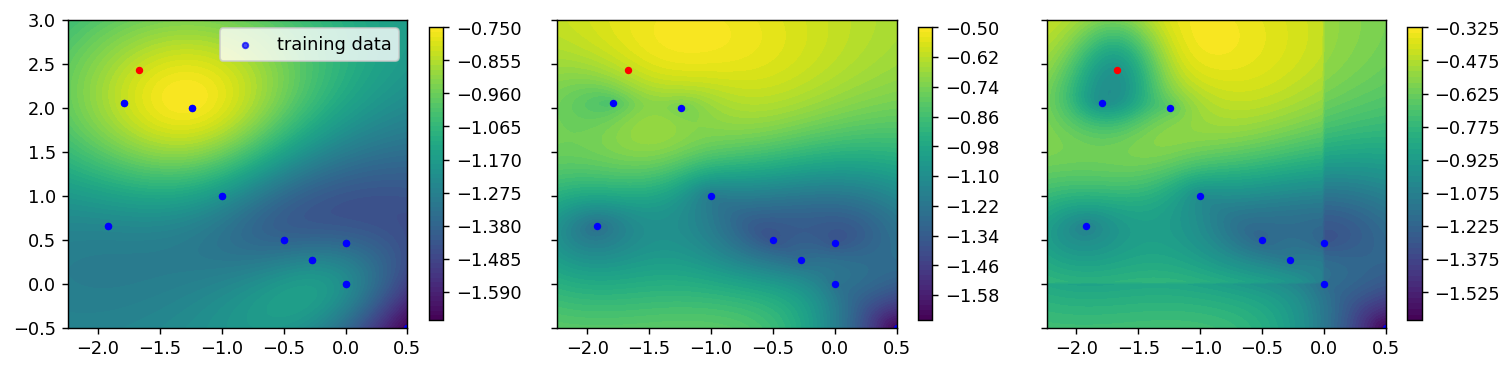

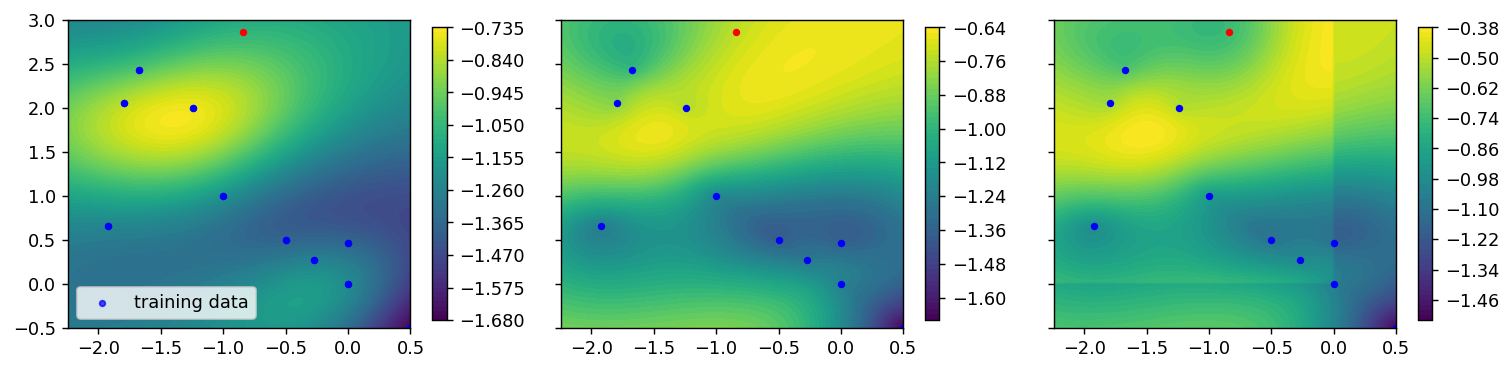

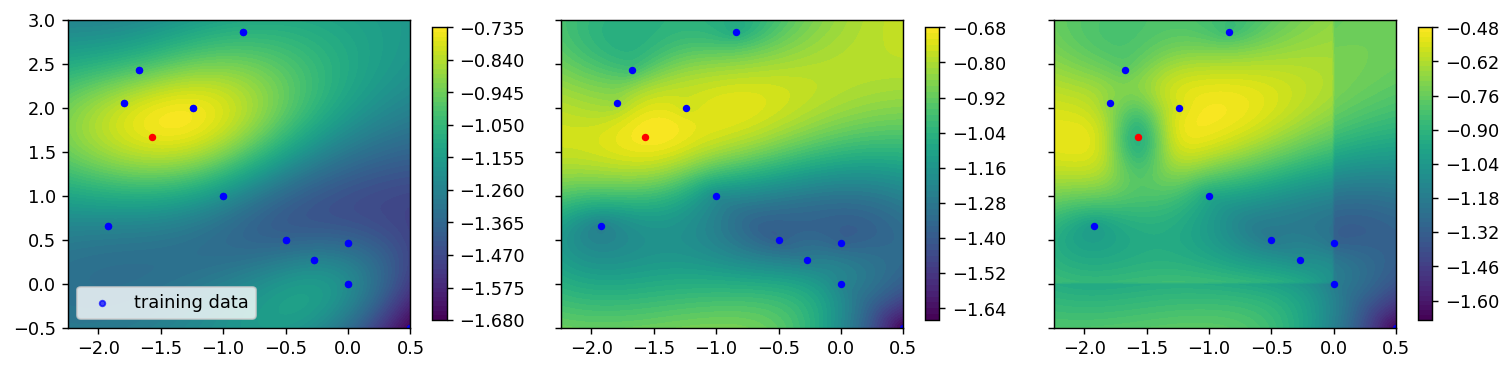

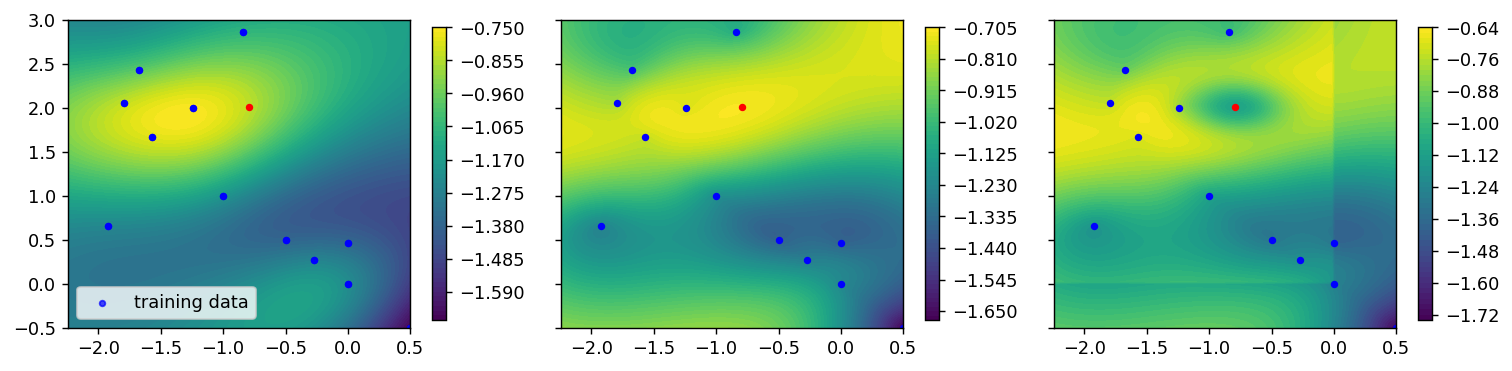

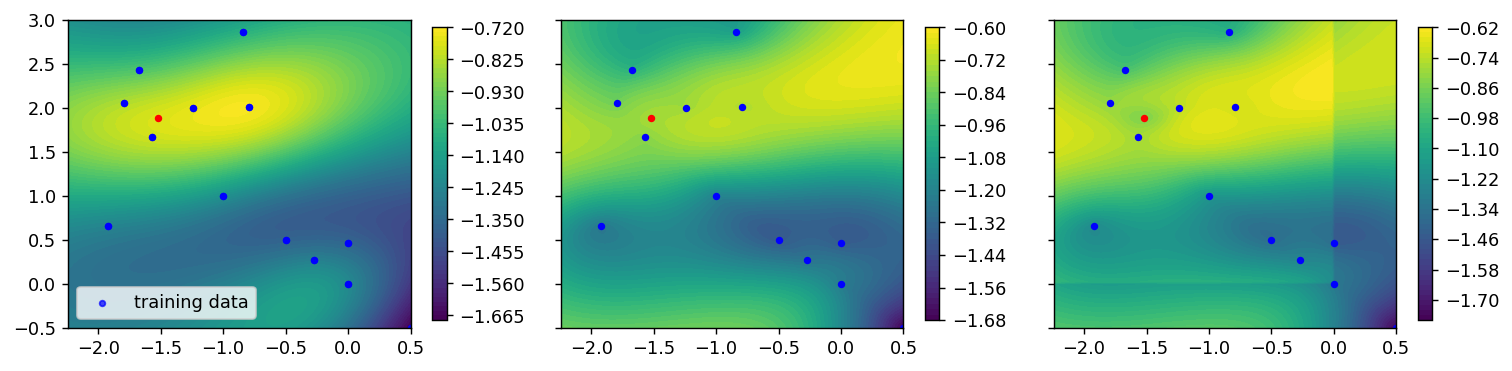

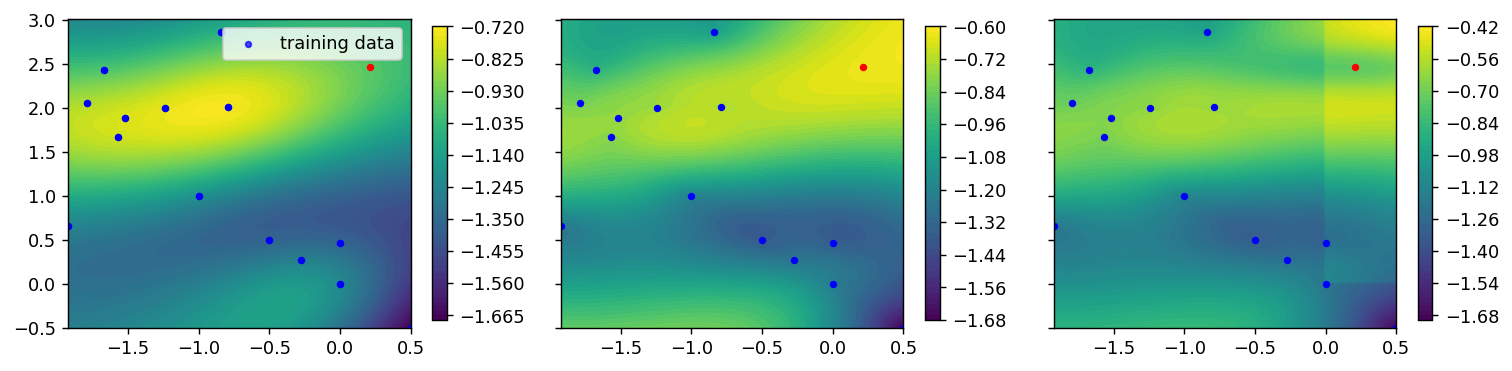

In [26]:
for i in range(10):
    ctrBO.optimize_local(1 , beta_scheduler=None)
    plot_compare_acqu(ctrBO)
    
for f in ctrBO.plot_callbacks:
    f.close()

# Visualize Surrogate model

[████████████████████████████████████████] 100%/100%



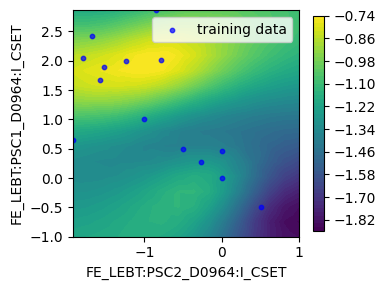

In [27]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4
bo = ctrBO.bo
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(7,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fig=fig,ax=ax_);
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()

<AxesSubplot: xlabel='evaluation budget', ylabel='best objective'>

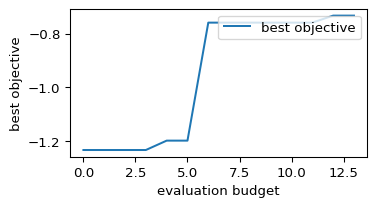

In [28]:
fig,ax = plt.subplots(figsize=(4,2),dpi=96)
ctrBO.bo.plot_obj_history(ax=ax, plot_best_only=True)